# Machine Learning for the Search for Extraterrestrial Intelligence

SETI Institute Code Challenge https://github.com/setiquest/ml4seti

### Classifying Radio Signals from Space with Keras

A CNN model is trained on a series of
simulated signals that imitate the observations of the SETI institute.


By converting radio signal data into a spectrogram (2D visual representation), the
problem can be transformed into something close to an image classification problem.

### Import some useful Libraries

In [1]:
from livelossplot.tf_keras import PlotLossesCallback
import pandas as pd
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt

import tensorflow as tf

from sklearn.metrics import confusion_matrix
from sklearn import metrics

import warnings;warnings.simplefilter('ignore')
%matplotlib inline
print('Tensorflow version:', tf.__version__)

C:\Users\a_mon\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\a_mon\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\a_mon\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\a_mon\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

Tensorflow version: 2.0.0-beta1


### Loading and preprocessing SETI Datasets

In [2]:
train_images = pd.read_csv('train_images.csv', header=None)
train_labels = pd.read_csv('train_labels.csv', header=None)

val_images = pd.read_csv('val_images.csv', header=None)
val_labels = pd.read_csv('val_labels.csv', header=None)

In [3]:
train_images.head()

,0,1,2,3,4,5,6,7,8,9,...,8182,8183,8184,8185,8186,8187,8188,8189,8190,8191
0,0.631373,0.623529,0.713726,0.705882,0.658824,0.666667,0.654902,0.635294,0.647059,0.705882,...,0.682353,0.611765,0.650980,0.658824,0.600000,0.603922,0.654902,0.694118,0.658824,0.666667
1,0.725490,0.752941,0.749020,0.701961,0.690196,0.721569,0.709804,0.745098,0.654902,0.721569,...,0.721569,0.698039,0.721569,0.686275,0.713726,0.682353,0.690196,0.698039,0.701961,0.725490
2,0.717647,0.701961,0.713726,0.733333,0.705882,0.717647,0.725490,0.682353,0.717647,0.674510,...,0.709804,0.694118,0.705882,0.682353,0.639216,0.713726,0.670588,0.678431,0.737255,0.674510
3,0.705882,0.674510,0.654902,0.678431,0.666667,0.662745,0.678431,0.662745,0.686275,0.686275,...,0.639216,0.662745,0.631373,0.643137,0.705882,0.662745,0.705882,0.666667,0.654902,0.631373
4,0.647059,0.729412,0.701961,0.674510,0.611765,0.698039,0.713726,0.662745,0.701961,0.674510,...,0.639216,0.670588,0.705882,0.674510,0.721569,0.694118,0.674510,0.705882,0.749020,0.729412


In [4]:
train_labels.head()

,0,1,2,3
0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0


In [5]:
print("Training set shape:", train_images.shape, train_labels.shape)
print("Validation set shape:", val_images.shape, val_labels.shape)

Training set shape: (3200, 8192) (3200, 4)
Validation set shape: (800, 8192) (800, 4)


In [6]:
x_train = train_images.values.reshape(3200, 64, 128, 1)
x_val = val_images.values.reshape(800, 64, 128, 1)

y_train = train_labels.values
y_val = val_labels.values

### Plotting 2D Spectrograms

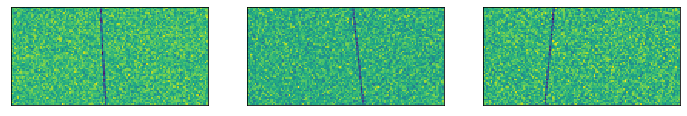

In [7]:
plt.figure(0, figsize=(12,12))
for i in range(1,4):
    plt.subplot(1,3,i)
    img = np.squeeze(x_train[np.random.randint(0, x_train.shape[0])])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)

### Create Training and Validation Data Generators

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen_train = ImageDataGenerator(horizontal_flip=True)
datagen_train.fit(x_train)

datagen_val = ImageDataGenerator(horizontal_flip=True)
datagen_val.fit(x_val)

### Creating the CNN Model

In [9]:
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

In [10]:
# Initialising the CNN
model = Sequential()

# 1st Convolution
model.add(Conv2D(32,(5,5), padding='same', input_shape=(64, 128,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# 2nd Convolution layer
model.add(Conv2D(64,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Flattening
model.add(Flatten())

# Fully connected layer
model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(4, activation='softmax'))

### Choosing Learning Rate and Compiling the Model

In [17]:
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=2,
    decay_rate=0.8,
    staircase=True)

optimizer = Adam(learning_rate=lr_schedule)

In [18]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 128, 32)       832       
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 128, 32)       128       
_________________________________________________________________
activation (Activation)      (None, 64, 128, 32)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 64, 64)        51264     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 64, 64)        2

### Training the Model

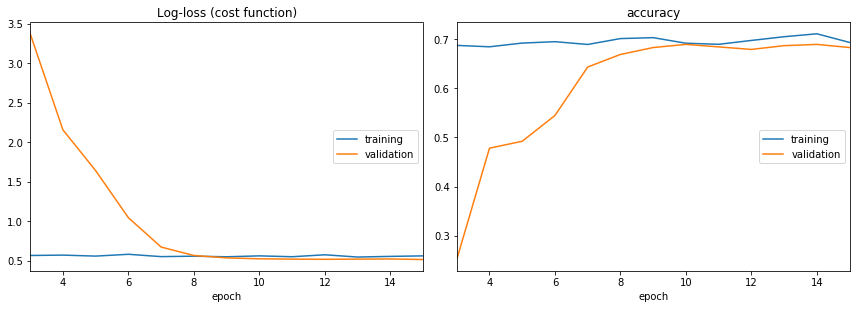

Log-loss (cost function):
training   (min:    0.546, max:    0.581, cur:    0.561)
validation (min:    0.515, max:    5.278, cur:    0.515)

accuracy:
training   (min:    0.685, max:    0.711, cur:    0.694)
validation (min:    0.242, max:    0.690, cur:    0.683)
106/106 [==============================] - 285s 3s/step - loss: 0.5614 - accuracy: 0.6937 - val_loss: 0.5152 - val_accuracy: 0.6833


In [19]:
checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_loss',
                             save_weights_only=True, mode='min', verbose=0)
callbacks = [PlotLossesCallback(), checkpoint]#, reduce_lr]
batch_size = 30
history = model.fit(
    datagen_train.flow(x_train, y_train, batch_size=batch_size, shuffle=True),
    steps_per_epoch=len(x_train)//batch_size,
    validation_data = datagen_val.flow(x_val, y_val, batch_size=batch_size, shuffle=True),
    validation_steps = len(x_val)//batch_size,
    epochs=15,
    callbacks=callbacks
)

### FInal Evaluation of the model

In [20]:
model.evaluate(x_val, y_val)

800/800 [==============================] - 8s 10ms/sample - loss: 0.5183 - accuracy: 0.6712


[0.5182527718906976, 0.67125]

In [21]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import seaborn as sns

y_true = np.argmax(y_val, 1)
y_pred = np.argmax(model.predict(x_val), 1)
print(metrics.classification_report(y_true, y_pred))
print("Classification accuracy: %0.6f" % metrics.accuracy_score(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.80      0.87       200
           1       0.44      0.52      0.47       200
           2       0.38      0.38      0.38       200
           3       1.00      1.00      1.00       200

    accuracy                           0.67       800
   macro avg       0.69      0.67      0.68       800
weighted avg       0.69      0.67      0.68       800

Classification accuracy: 0.671250


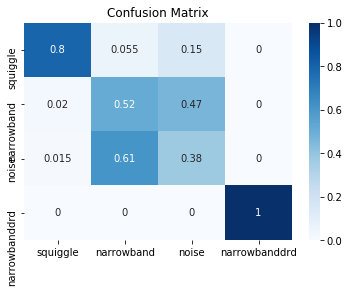

In [22]:
labels = ["squiggle", "narrowband", "noise", "narrowbanddrd"]

ax= plt.subplot()
sns.heatmap(metrics.confusion_matrix(y_true, y_pred, normalize='true'), annot=True, ax = ax, cmap=plt.cm.Blues); #annot=True to annotate cells

# labels, title and ticks
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);